In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [41]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "PlantVillage",
            shuffle = True,
            image_size = (IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [42]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [43]:
class_dict = {}
count  = 0
for names in class_names:
    class_dict[names] = count
    count = count + 1
class_dict

{'Tomato_Bacterial_spot': 0,
 'Tomato_Early_blight': 1,
 'Tomato_Late_blight': 2,
 'Tomato_Leaf_Mold': 3,
 'Tomato_Septoria_leaf_spot': 4,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 5,
 'Tomato__Target_Spot': 6,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 7,
 'Tomato__Tomato_mosaic_virus': 8,
 'Tomato_healthy': 9}

In [44]:
len(dataset)

501

In [45]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[7 7 7 2 0 3 7 7 4 2 9 7 4 2 3 0 7 9 7 2 9 5 7 2 7 7 2 6 7 9 2 0]


In [46]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[ 88.  93. 112.]
  [ 95. 100. 119.]
  [ 96. 101. 120.]
  ...
  [115. 123. 144.]
  [117. 125. 146.]
  [123. 131. 152.]]

 [[104. 109. 128.]
  [104. 109. 128.]
  [100. 105. 124.]
  ...
  [114. 122. 143.]
  [110. 118. 139.]
  [112. 120. 141.]]

 [[103. 108. 127.]
  [ 96. 101. 120.]
  [ 87.  92. 111.]
  ...
  [109. 117. 138.]
  [113. 121. 142.]
  [119. 127. 148.]]

 ...

 [[ 92.  97. 116.]
  [ 89.  94. 113.]
  [ 91.  96. 115.]
  ...
  [127. 135. 154.]
  [121. 129. 148.]
  [122. 130. 149.]]

 [[ 93.  98. 117.]
  [ 90.  95. 114.]
  [ 93.  98. 117.]
  ...
  [125. 133. 152.]
  [120. 128. 147.]
  [109. 117. 136.]]

 [[ 95. 100. 119.]
  [ 93.  98. 117.]
  [ 97. 102. 121.]
  ...
  [109. 117. 136.]
  [109. 117. 136.]
  [ 92. 100. 119.]]]


In [47]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


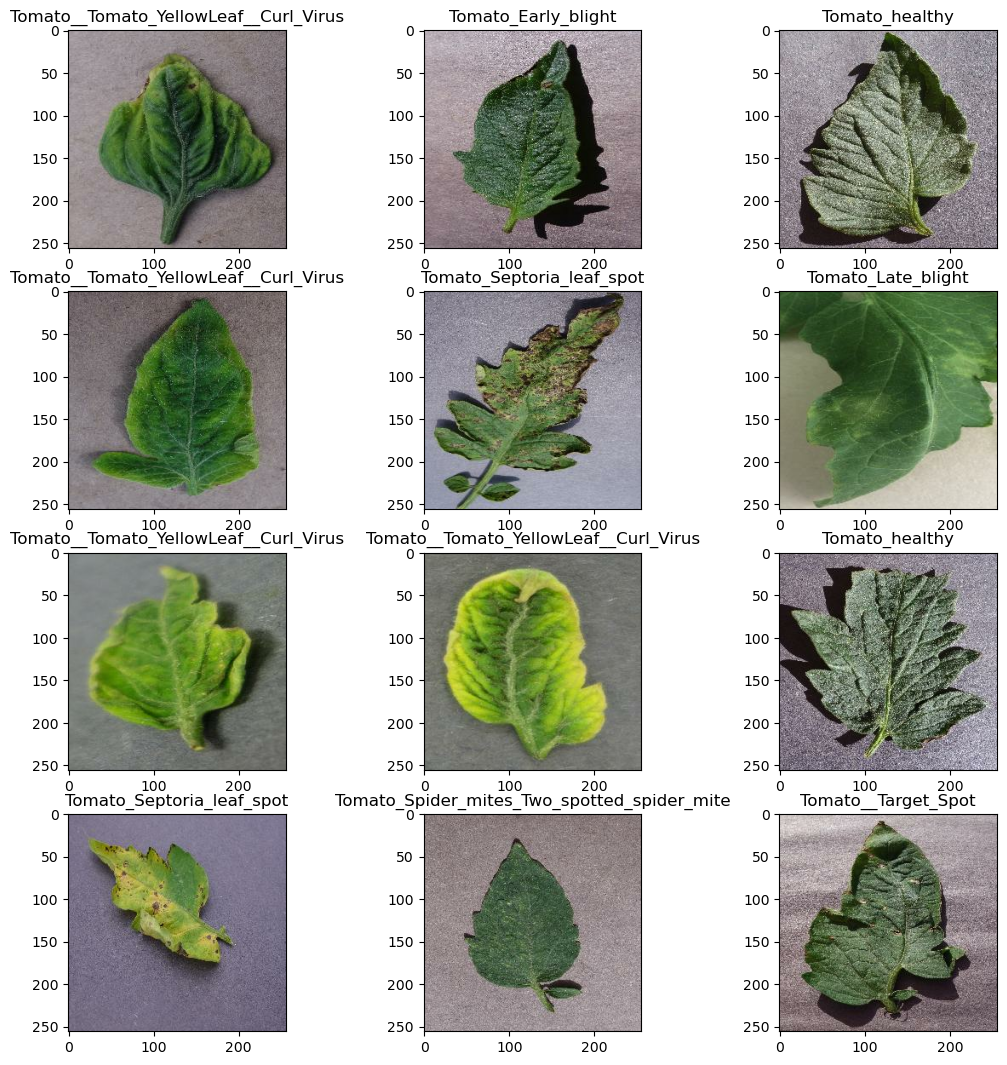

In [48]:
plt.figure(figsize=(13,13))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [49]:
train_size = 0.8
len(dataset)*train_size

400.8

In [50]:
train_ds = dataset.take(400)
len(train_ds)

400

In [51]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [52]:
val_size = 0.1
len(dataset)*val_size

50.1

In [53]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [54]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [55]:
def get_dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size =400):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds1 = ds.take(train_size)
    val_ds1 = ds.skip(train_size).take(val_size)
    test_ds1 = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [56]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [57]:
print("Length of training datset : ",len(train_ds))
print("Length of the validation dataset : ",len(val_ds))
print("Lenght of the test dataset : ",len(test_ds))

Length of training datset :  400
Length of the validation dataset :  50
Lenght of the test dataset :  51


In [58]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [59]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [60]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [61]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [64]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['accuracy']
)

In [ ]:
history = model.fit(
        train_ds,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        verbose = 1,
        validation_data = val_ds
)

Epoch 1/40
205/400 [==============>...............] - ETA: 9:01 - loss: 1.8822 - accuracy: 0.3297

In [30]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 45s 496ms/step - loss: 0.4119 - accuracy: 0.8790


In [31]:
scores

[0.4119449555873871, 0.8789571523666382]

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

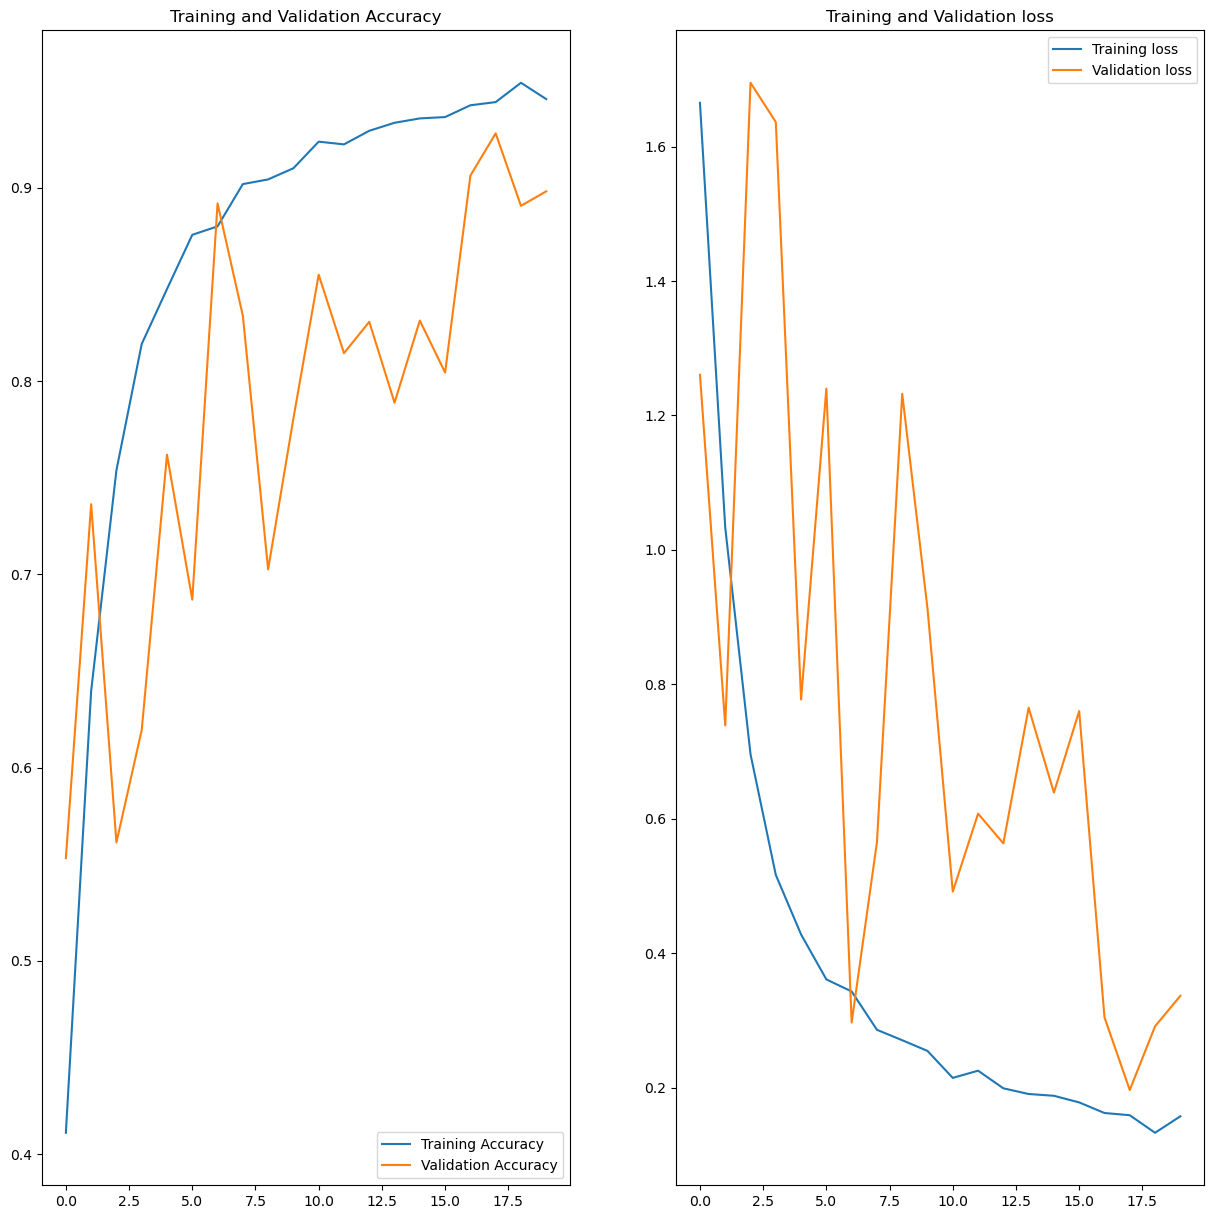

In [34]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

Actual label :  Tomato_Early_blight
1/1 [==============================] - 1s 1s/step
Predicted label :  Tomato_Early_blight


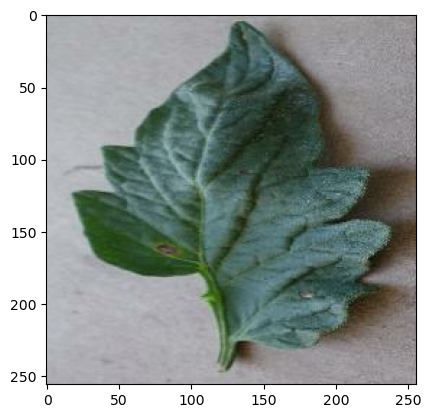

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Actual label : ", class_names[first_label])
    plt.imshow(first_image)
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label : ", class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


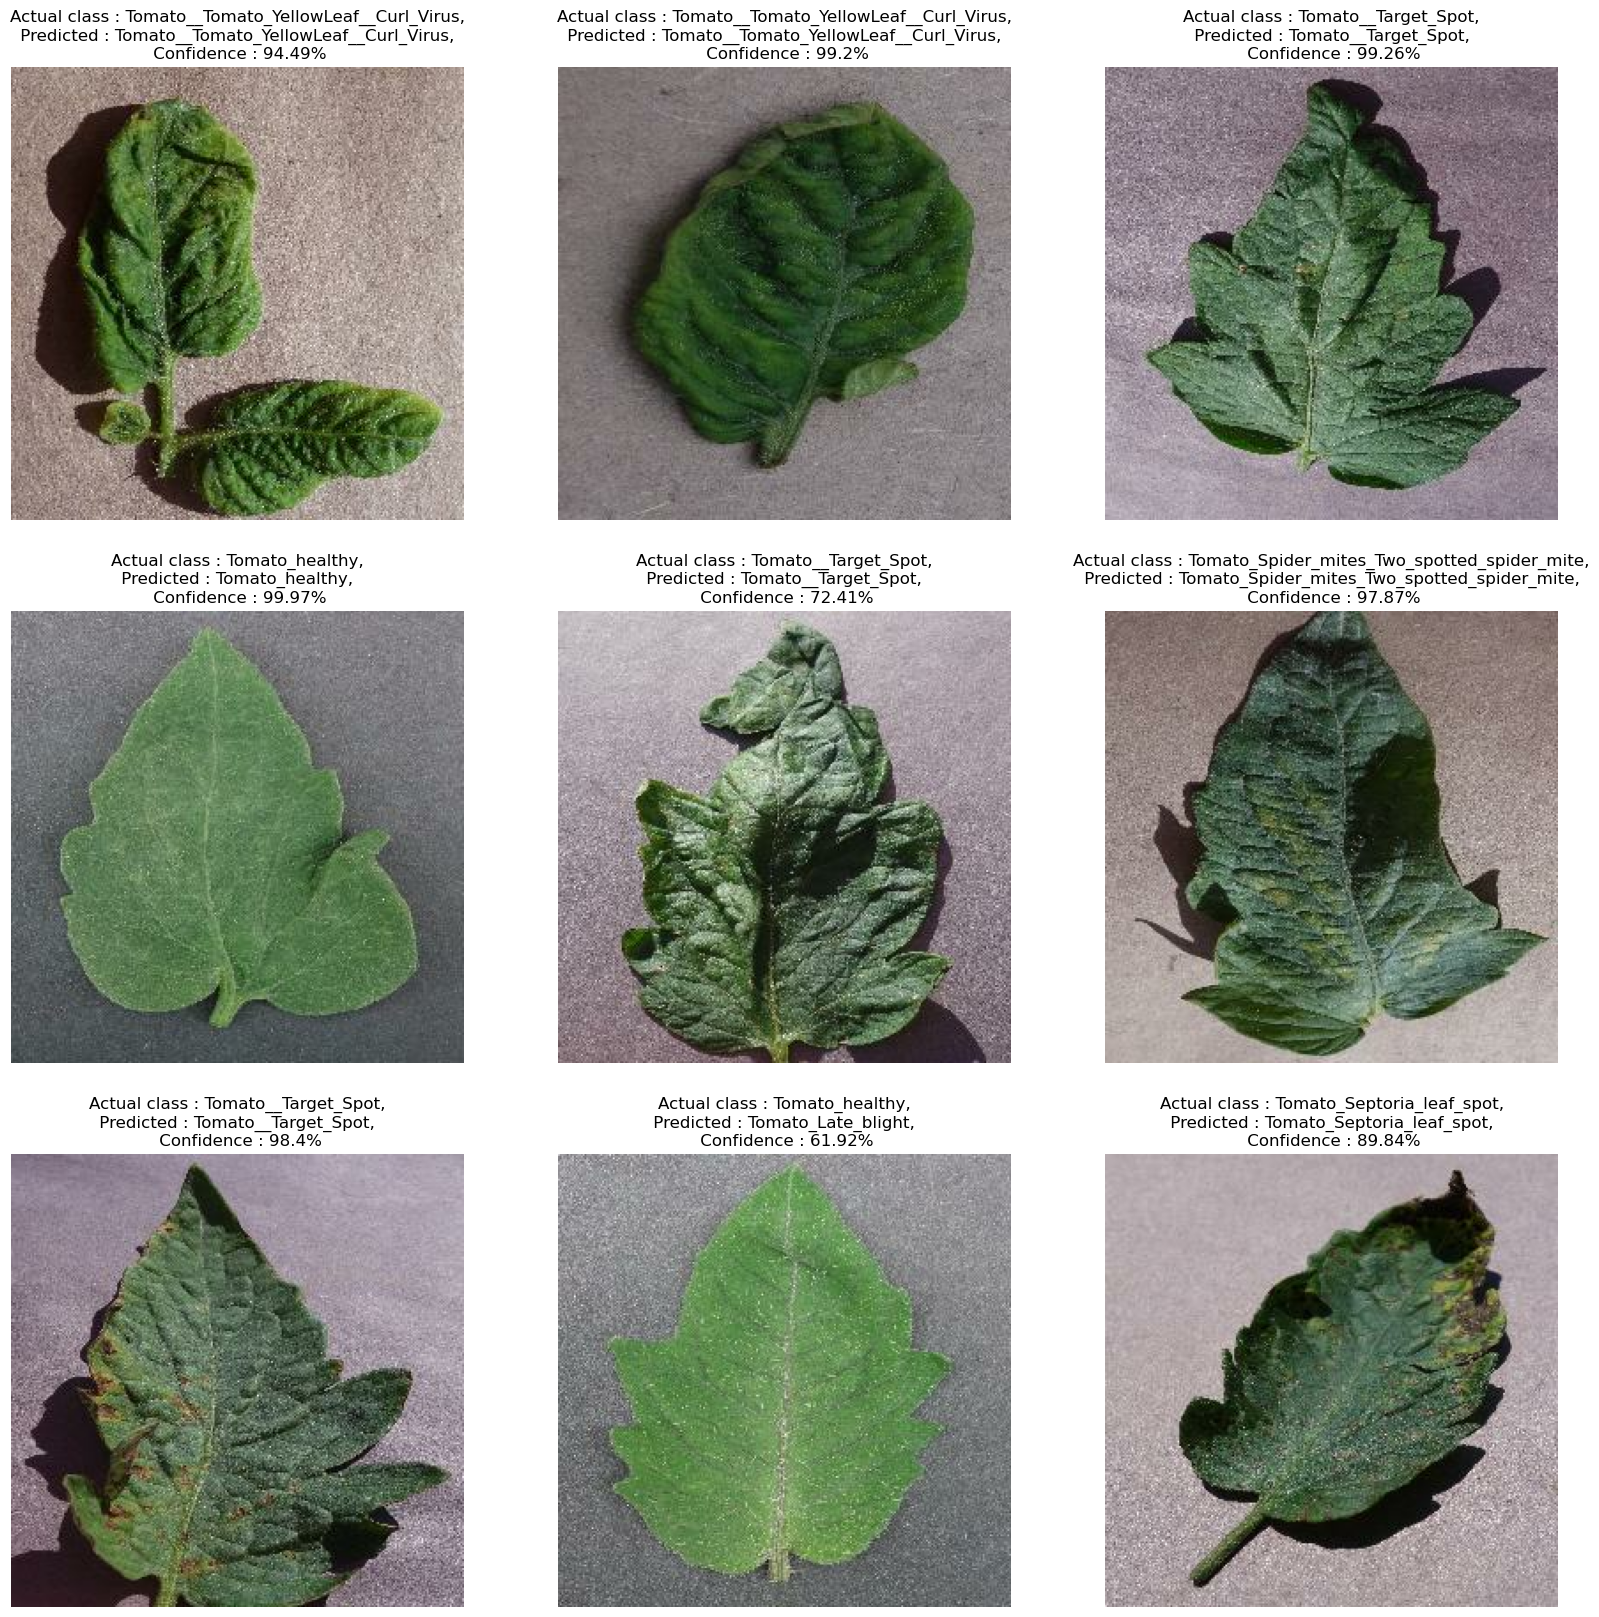

In [37]:
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual class : {actual_class},\n Predicted : {predicted_class}, \n Confidence : {confidence}%")
        plt.axis("off")

In [38]:
model.save('model.h5')